### Predicting incidence of breast cancer using Wisconsin Diagnostic Dataset

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reference for customizing plots : http://matplotlib.org/users/customizing.html
# print(plt.style.available)

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
print("Classes {}".format(np.unique(y)))
print 
print data.DESCR

Classes [0 1]

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Ra

In [12]:
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = {'gb':GradientBoostingClassifier(), 
          'mlp':MLPClassifier(), 
          'knn':KNeighborsClassifier(), 
          'reg':LogisticRegression()}

for model_key in models:
    model = models[model_key]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    print "F1 for {0}: {1}".format(model_key, f1)


F1 for knn: 0.957142857143
F1 for mlp: 0.950354609929
F1 for gb: 0.985915492958
F1 for reg: 0.965034965035


### Estimate Variable Importance

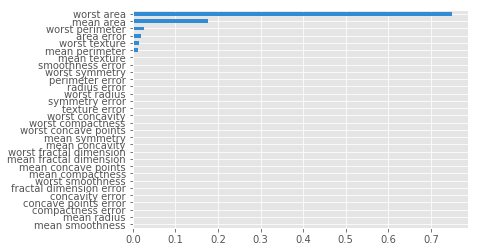

In [13]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_test, feature_names=data.feature_names)
model = InMemoryModel(models['knn'].predict_proba, examples=X_train)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending = False)

### Skater also works with classifiers without probability scores

To enable classifier.predict methods, we need to tell the skater model object what the unique classes are, i.e. the set of possible values one could obtain from classifier.predict, with the `unique_values` argument. This is because Skater's algorithms need to know how perturbations in the input affect output frequencies. These possible outputs are obvious in regressions and classifiers that return probabilities, but need to be explicitly stated when MLE classes are returned.

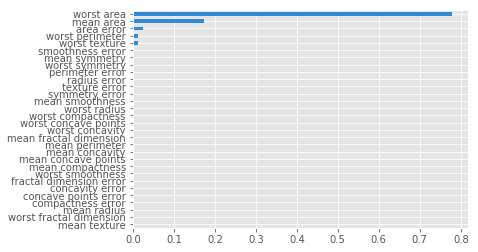

In [14]:
model_no_proba = InMemoryModel(models['knn'].predict, 
                      examples=X_train, 
                      unique_values=models['knn'].classes_)
plots = interpreter.feature_importance.plot_feature_importance(model_no_proba, ascending = False)

### Comparing variable importance across all models

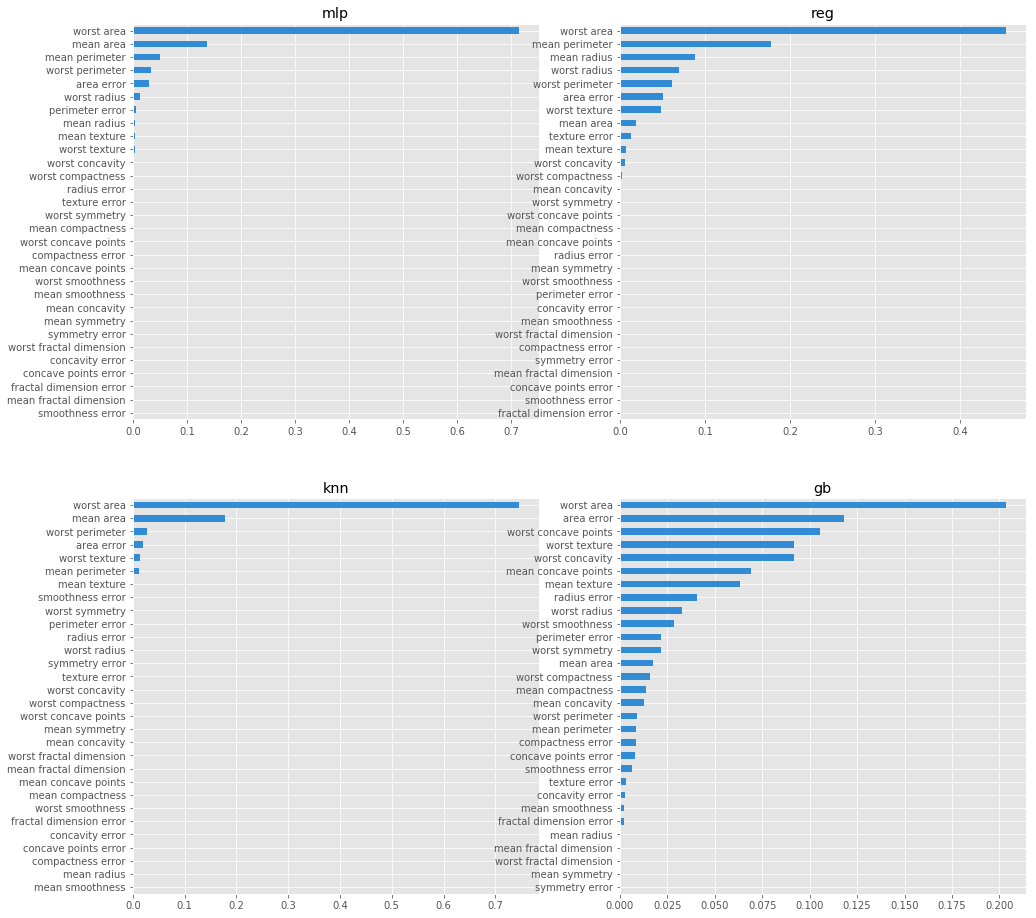

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

f, axes = plt.subplots(2,2, figsize = (16, 16))

ax_dict = {
    'mlp':axes[0][0],
    'knn':axes[1][0],
    'reg':axes[0][1],
    'gb':axes[1][1]
}

interpreter = Interpretation(X_test, feature_names=data.feature_names)

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ax=ax, ascending = False)
    ax.set_title(model_key)

### Use partial dependence to understand the relationship between a variable and a model's predictions

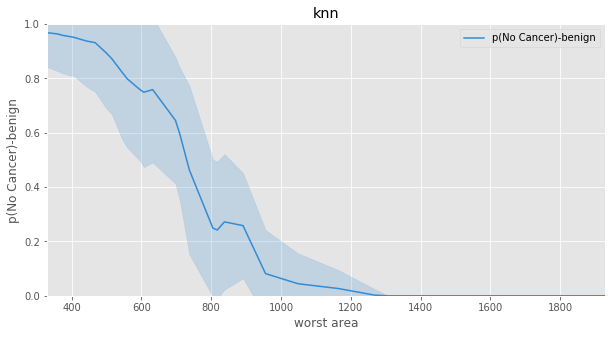

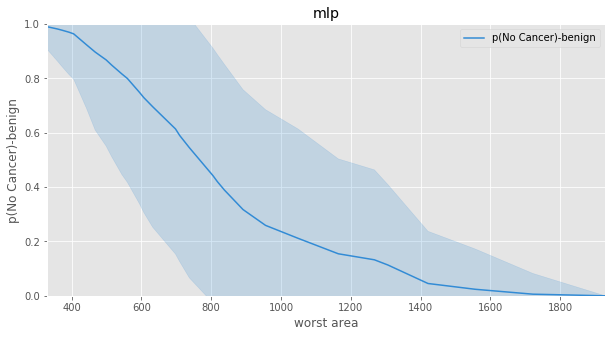

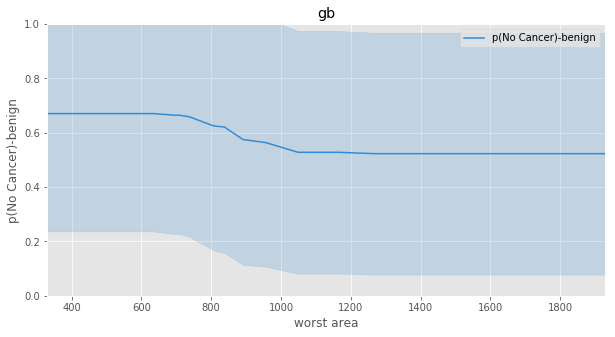

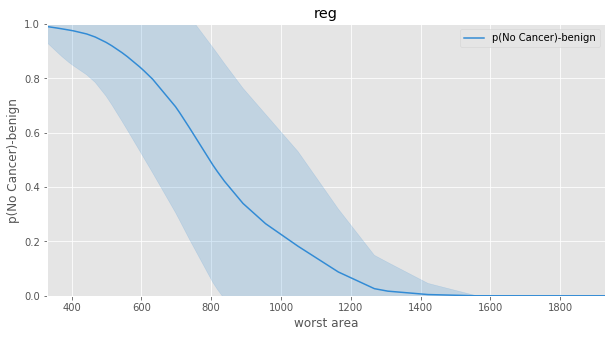

In [17]:
for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train, target_names=['p(Cancer)-malignant', 'p(No Cancer)-benign'])
    axes_list = interpreter.partial_dependence.plot_partial_dependence(['worst area'],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True,
                                                                       figsize = (10, 5))
    ax = axes_list[0][1]
    ax.set_title(model_key)
    ax.set_ylim(0, 1)

### Why isnt gb as sensitive to worst area? 

* **Feature importance indicates gb uses more features, perhaps theres additivity?** 
* **Lets use LIME to approximate the model with a regression, locally around a point **

In [19]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_train, 
                           feature_names=data.feature_names, 
                           discretize_continuous=True, 
                           class_names=['p(Cancer)-malignant', 'p(No Cancer)-benign'])
exp.explain_instance(X_train[0], models['gb'].predict_proba).show_in_notebook()

In [20]:
exp.explain_instance(X_train[0], models['knn'].predict_proba).show_in_notebook()

### Interaction between worst area and perimeter for gb model?

[[<matplotlib.figure.Figure at 0x7fed9b2b9d50>,

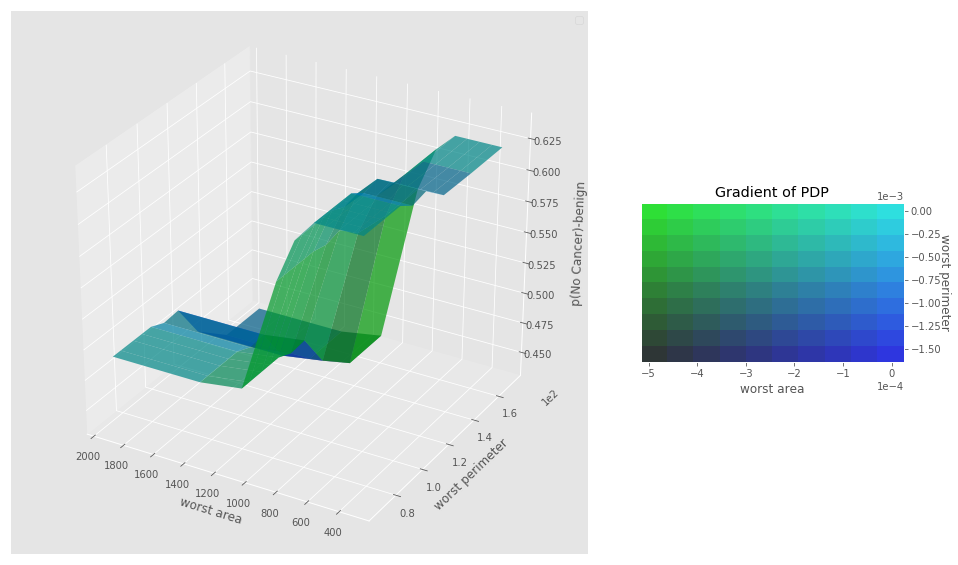

In [23]:
model = InMemoryModel(models['gb'].predict_proba, examples=X_train, target_names=['p(Cancer)-malignant', 
                                                                                  'p(No Cancer)-benign'])
interpreter.partial_dependence.plot_partial_dependence([('worst area', 'worst perimeter')], model, 
                                                       grid_resolution=10)

### Explore the relationship interactively

In [26]:
%matplotlib notebook
#interpreter.partial_dependence.plot_partial_dependence([('worst area', 
#                                                         'worst perimeter')], 
#                                                       model, 
#                                                       grid_resolution = 30, 
#                                                       figsize = (11, 5))